In [4]:
import glob, os
from PIL import Image
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, Activation, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information


In [39]:
food_list = ['갈비구이', '제육볶음', '짬뽕', '삼겹살', '짜장면', '삼계탕', '불고기', '곰탕_설렁탕', '칼국수', '훈제오리']

['갈비구이', '제육볶음', '짬뽕', '삼겹살', '짜장면', '삼계탕', '불고기', '곰탕_설렁탕', '칼국수', '훈제오리']

In [46]:
img_path = 'top10_food/'

In [47]:
## 사진 사이즈 변경해서 np array로 변경

image_size = 32

# x_train = []
x_test = []
# y_train = []
y_test = []

for tt in ['test']:
    print(tt)
    for i, food in enumerate(food_list):
        path = img_path + food + '/' + tt 
        print(food, end = ',')
         
        files = []
        files.extend(glob.glob(path + '/*'))

        for file in files:
            img = Image.open(file)
            img = img.convert("RGB") # 색상 모드 변경
            img = img.resize((image_size, image_size)) # 이미지 크기 변경

            data = np.asarray(img)
            
            globals()['x_{}'.format(tt)].append(data)
            globals()['y_{}'.format(tt)].append(i)
    print()

# x_train = np.asarray(x_train)
# y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

test
갈비구이,제육볶음,짬뽕,삼겹살,짜장면,삼계탕,불고기,곰탕_설렁탕,칼국수,훈제오리,


In [49]:
y_test_reshape = y_test.reshape(-1, 1)
x_test = np.array(x_test) / 127.5 - 1

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True )


# hyperparameters
K = 32
init_ch = 64 # 가장 첫 layer의 채널 수 입니다.
compression = 0.5 # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5 사용

inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)



def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)

        x = concatenate([x, tmp])

    return x



def transition_block(x):
    shape = x.get_shape().as_list() # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression) # compression 비율만큼 channel을 줄여 줍니다.

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)
x = dense_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)
dense121 = Model(input_img, x)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import math

def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5',
                             save_best_only=True,
                             save_weights_only=True)

In [11]:
filename = "model_50.h5"
dense121.load_weights(filename)
dense121

# dense121.compile(optimizer=Adam(0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# score = dense121.evaluate(x_test, y_test)

# print('test score:', score[0])
# print('test accuracy:', score[1])

2007/2007 [==============================] - 11s 6ms/sample - loss: 3.9352 - acc: 0.3842
test score: 3.935170345658025
test accuracy: 0.38415545

100/100 [==============================] - 2s 24ms/sample - loss: 3.0945 - acc: 0.5200
test score: 3.0944990921020508
test accuracy: 0.52

In [60]:
predicted = [np.argmax(i) for i in dense121.predict(x_test)]

In [88]:
count = 0
for i in range(100):
    if len(food_list[predicted[i]]) > 5:
        print('예측: '+ food_list[predicted[i]] + '\t/\t실제 값: '+ food_list[y_test[i]], end='')
    else: 
        print('예측: '+ food_list[predicted[i]] + '\t\t/\t실제 값: '+ food_list[y_test[i]], end='')
        
    if food_list[predicted[i]] == food_list[y_test[i]]:
        print('\t----  정답!')
    else:
        print()
    count += 1
    if count == 10:
        count=0
        print()

예측: 불고기		/	실제 값: 갈비구이
예측: 짜장면		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 불고기		/	실제 값: 갈비구이
예측: 제육볶음		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 삼겹살		/	실제 값: 갈비구이
예측: 갈비구이		/	실제 값: 갈비구이	----  정답!
예측: 삼겹살		/	실제 값: 갈비구이

예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짬뽕		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짜장면		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 삼겹살		/	실제 값: 제육볶음
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 제육볶음		/	실제 값: 제육볶음	----  정답!
예측: 짬뽕		/	실제 값: 제육볶음

예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 삼겹살		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 갈비구이		/	실제 값: 짬뽕
예측: 짬뽕		/	실제 값: 짬뽕	----  정답!
예측: 제육볶음		/	실제 값: 짬뽕

예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 불고기		/	실제 값: 삼겹살
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹살	----  정답!
예측: 삼겹살		/	실제 값: 삼겹

In [13]:
def get_img_by_url(url):
    urllib.request.urlretrieve(url, 'temp.jpg')
    img = Image.open('temp.jpg')

    img = img.convert("RGB") # 색상 모드 변경
    img = img.resize((32, 32)) # 이미지 크기 변경

    img = np.asarray(img)
    img = np.array(img) / 127.5 - 1
    
    return img.reshape(-1, 32, 32, 3)


def get_img_from_local(path, img_name):
    img = Image.open(img_name)
    img = img.convert("RGB") # 색상 모드 변경
    img = img.resize((32, 32)) # 이미지 크기 변경

    img = np.asarray(img)
    img = np.array(img) / 127.5 - 1
    
    return img.reshape(-1, 32, 32, 3)


def view_img_byurl(url):
    urllib.request.urlretrieve(url, 'temp.jpg')
    plt.imshow(Image.open('temp.jpg'))
    
def view_img(path, file):
    plt.imshow(Image.open(path + file))
    
def predict_by_model(model, data):
    return print(food_list[np.argmax(model.predict(data))])

'짬뽕'

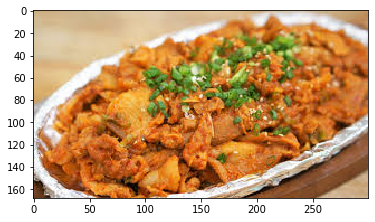

In [121]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRZVo6yeJJ0qIt4HPjoQ-meC7q5HXCABBRdosyMGSa04AvWFYdf&s"
view_img_byurl(url)
# food_list[np.argmax(dense121.predict(get_img_by_url(url)))]
predict_by_model(dense121, get_img_by_url(url))

삼겹살


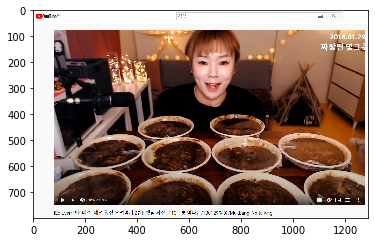

In [132]:
view_img('', 'youtube_2.PNG')
predict_by_model(dense121, get_img_from_local('/', 'youtube_2.PNG'))

짜장면


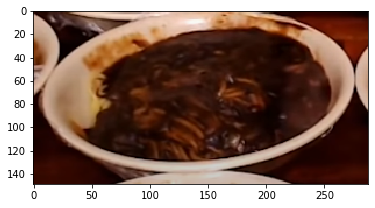

In [133]:
view_img('', 'youtube_2_closeup.PNG')
predict_by_model(dense121, get_img_from_local('/', 'youtube_2_closeup.PNG'))

6